In [1]:
%pip install pandas
%pip install torch torchvision
%pip install opencv-python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from PIL import Image
import json
import os
import cv2
import random
from itertools import combinations

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Preparing the data (Load and manage the images and labels)

# Dictionary to map card labels to integers.
card_to_int = {
    'Ah': 51, 'Ac': 50, 'Ad': 49, 'As': 48,
    'Kh': 47, 'Kc': 46, 'Kd': 45, 'Ks': 44,
    'Qh': 43, 'Qc': 42, 'Qd': 41, 'Qs': 40,
    'Jh': 39, 'Jc': 38, 'Jd': 37, 'Js': 36,
    'Th': 35, 'Tc': 34, 'Td': 33, 'Ts': 32,
    '9h': 31, '9c': 30, '9d': 29, '9s': 28,
    '8h': 27, '8c': 26, '8d': 25, '8s': 24,
    '7h': 23, '7c': 22, '7d': 21, '7s': 20,
    '6h': 19, '6c': 18, '6d': 17, '6s': 16,
    '5h': 15, '5c': 14, '5d': 13, '5s': 12,
    '4h': 11, '4c': 10, '4d': 9, '4s': 8,
    '3h': 7, '3c': 6, '3d': 5, '3s': 4,
    '2h': 3, '2c': 2, '2d': 1, '2s': 0
}

root_dir = "C:/Users/Admin/Desktop/Primary Skills/Programming & ML/Machine Learning/Kaggle/Card Detection"
num_classes = 52

# Create subclass of the pytorch base custom dataset.
class ImageDataset(torch.utils.data.Dataset):

    # Initializes the parameters and loads in the native data.
    def __init__(self, root_dir, folder_name, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.folder_name = folder_name
        self.card_info = os.listdir(os.path.join(root_dir, folder_name))

    # Gets total number of samples, used to determine the number of iterations required to go through entire dataset.
    def __len__(self):
        return len(self.card_info)

    # Load and return a sample from the dataset given an index. When using data loaders, this is called to fetch a specific sample from the dataset.
    def __getitem__(self, idx):

        # Retrieves the card image name and path and then extracts the truth label as the images name before '.png'.
        img_name = self.card_info[idx]
        img_path = os.path.join(root_dir, self.folder_name, img_name)
        card_label = img_name[:-4]
        label = card_to_int[card_label]
        
        # Opens the image via the card and table image paths. Converts images to RGB that were currently RGB with Alpha (RGBA). Returns image and label.
        img = Image.open(img_path)
        img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label
    
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cards_dataset = ImageDataset(root_dir=root_dir, folder_name='Card Images', transform=transform)
train_loader = DataLoader(cards_dataset, batch_size=8, shuffle=True)

test_cards_dataset = ImageDataset(root_dir=root_dir, folder_name='Test Card Images', transform=transform)
test_loader = DataLoader(test_cards_dataset, batch_size=1, shuffle=False)

print("Data preparation completed.")
print(f"Number of samples in training dataset: {len(cards_dataset)}")

Data preparation completed.
Number of samples in training dataset: 52


In [13]:
# Building the model (Creating custom CNN 'CardCNN' using nn.Module class)
class CardCNN(nn.Module):
    # Initialization function
    def __init__(self):
        # Constructor which initializes the layers and defines parameters.
        super(CardCNN, self).__init__()
        # convolutional layer for extracting local features/patterns. (input channels, output channels, kernel size, stride).
        self.conv1 = nn.Conv2d(3, 4, 3, 1)
        # max pooling layer for downsampling to retain important features & reduce spatial dimensions. (kernel size, stride).
        self.pool = nn.MaxPool2d(2, 2)
        # convolutional layer for extracting local features/patterns. (input channels, output channels, kernel size, stride).
        self.conv2 = nn.Conv2d(4, 8, 3, 1)
        # fully connected layer which flattens for classification. (input size, output size).
        self.fc1 = nn.Linear(8 * 5 * 8, num_classes)

    # Function to define how the input flows through the layers.
    def forward(self, x):
        # Applies convolutional layer, activation function (ReLU) for non-linearity, and pooling layer to the input.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Reshapes the output tensor to match the input size of the fully connected layer.
        x = x.view(-1, 8 * 5 * 8)
        # Applies fully connected layer.
        x = self.fc1(x)
        # Logarithmic softmax function applied to produce the output probabilities.
        return F.log_softmax(x, dim=1)

model = CardCNN()
print(model)

CardCNN(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=52, bias=True)
)


Epoch 10, Loss: 1.5880084889275687, Accuracy: 80.77%
Epoch 20, Loss: 0.12036078103951045, Accuracy: 100.00%
Epoch 30, Loss: 0.0316807505275522, Accuracy: 100.00%
Epoch 40, Loss: 0.013468674384057522, Accuracy: 100.00%
Epoch 50, Loss: 0.00771892669477633, Accuracy: 100.00%
Finished training


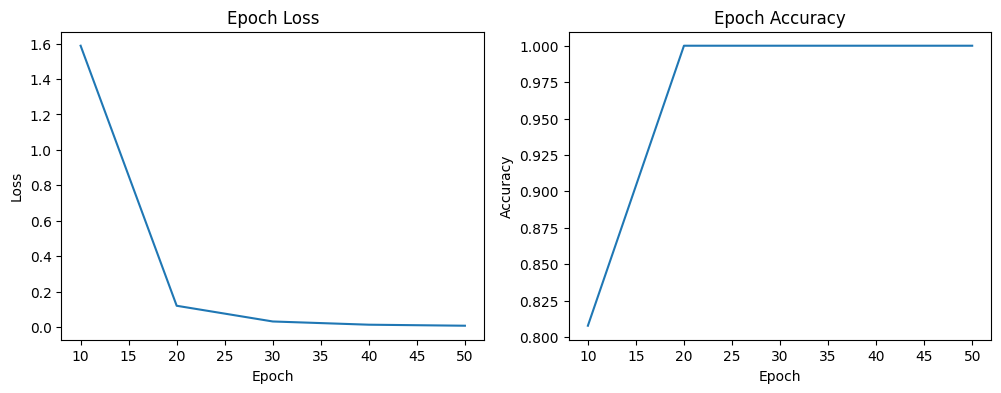

In [14]:
# Training the model on the individual cards

# Device selection
device = torch.device("cpu")
model.to(device)

# Optimizer using an algo during training with the set learning rate. (SGD, Adam, AdamW, RMSprop, etc.)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# Loss function (combines softmax activation and negative log-likelihood loss).
criterion = nn.CrossEntropyLoss()

num_epochs = 50
print_frequency = 10
# List to store the average loss and accuracy for each epoch
losses = []  
accuracies = []

# Loop through the number of epochs.
for epoch in range(num_epochs):
    # Initialize the running loss.
    running_loss = 0.0
    # New
    correct_predictions = 0
    #iterate over the DataLoader (train_loader) to get batches of input images and their labels.
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Move the inputs and labels to the appropriate device (CPU or GPU).
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear the gradients of the model parameters before each forward pass.
        optimizer.zero_grad()
        # Pass the input images through the model to get the predicted outputs.
        outputs = model(inputs)
        # Calculate the loss between the predicted outputs and the ground truth labels.
        loss = criterion(outputs, labels)
        # Perform backpropagation to compute gradients of the loss with respect to the model parameters.
        loss.backward()
        # Update the model parameters using the optimizer.
        optimizer.step()
        # Accumulate the running loss for each batch.
        running_loss += loss.item()
        
        # Calculate the predicted class and the number of correct predictions
        _, predicted = torch.max(outputs, dim=1)
        correct_predictions += (predicted == labels).sum().item()

    # Print the average loss every print_frequency epochs
    if (epoch + 1) % print_frequency == 0:
        average_loss = running_loss / (i + 1)
        accuracy = correct_predictions / (len(train_loader.dataset))
        # Append the average loss and accuracy to the appropriate empty lists.
        losses.append(average_loss) 
        accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy * 100:.2f}%")

print("Finished training")

# Plotting the epoch loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(print_frequency, num_epochs + 1, print_frequency), losses)
ax1.set(xlabel='Epoch', ylabel='Loss', title='Epoch Loss')
ax2.plot(range(print_frequency, num_epochs + 1, print_frequency), accuracies)
ax2.set(xlabel='Epoch', ylabel='Accuracy', title='Epoch Accuracy')
plt.show()

In [15]:
torch.save(model.state_dict(), "card_detector.pth")

loaded_model = CardCNN()
loaded_model.load_state_dict(torch.load("card_detector.pth"))
loaded_model.eval()

CardCNN(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=52, bias=True)
)

In [16]:
# Move the model to the appropriate device (CPU or GPU).
loaded_model.to(device)

# Initialize the list of predicted labels.
predicted_labels = []

# Iterate through the test dataset.
for inputs, _ in test_loader:
    # Move the inputs to the appropriate device (CPU or GPU).
    inputs = inputs.to(device)

    # Pass the input images through the loaded model to get the predicted outputs.
    outputs = loaded_model(inputs)

    # Find the class with the highest probability.
    _, predicted = torch.max(outputs, dim=1)

    # Append the predicted label to the list of predicted labels.
    predicted_labels.append(predicted.item())

print(predicted_labels)

[2, 1, 3, 0, 5, 7, 10, 9, 11, 8, 14, 13, 15, 12, 18, 17, 16, 22, 21, 23, 20, 26, 24, 30, 29, 31, 28, 49, 51, 48, 38, 37, 39, 36, 46, 45, 47, 44, 42, 41, 43, 40, 34, 32]


In [17]:
full_range = set(range(0, 52))
predicted_labels_set = set(predicted_labels)
missing_integers = full_range - predicted_labels_set
print("Missing cards:", missing_integers)

Missing cards: {33, 35, 4, 6, 50, 19, 25, 27}


In [18]:
unique_combinations = list(combinations(missing_integers, 4))

def sort_cards(combo):
    return sorted(combo, reverse=True)

sorted_combinations = [sort_cards(combo) for combo in unique_combinations]
print(sorted_combinations)

def sort_combinations_by_power(combinations):
    return sorted(combinations, key=lambda combo: combo, reverse=True)

sorted_combinations_by_power = sort_combinations_by_power(sorted_combinations)
print(sorted_combinations_by_power)

int_to_card = {v: k for k, v in card_to_int.items()}
sorted_card_combinations = [[int_to_card[i] for i in combo] for combo in sorted_combinations_by_power]
print(sorted_card_combinations)

[[35, 33, 6, 4], [50, 35, 33, 4], [35, 33, 19, 4], [35, 33, 25, 4], [35, 33, 27, 4], [50, 35, 33, 6], [35, 33, 19, 6], [35, 33, 25, 6], [35, 33, 27, 6], [50, 35, 33, 19], [50, 35, 33, 25], [50, 35, 33, 27], [35, 33, 25, 19], [35, 33, 27, 19], [35, 33, 27, 25], [50, 33, 6, 4], [33, 19, 6, 4], [33, 25, 6, 4], [33, 27, 6, 4], [50, 33, 19, 4], [50, 33, 25, 4], [50, 33, 27, 4], [33, 25, 19, 4], [33, 27, 19, 4], [33, 27, 25, 4], [50, 33, 19, 6], [50, 33, 25, 6], [50, 33, 27, 6], [33, 25, 19, 6], [33, 27, 19, 6], [33, 27, 25, 6], [50, 33, 25, 19], [50, 33, 27, 19], [50, 33, 27, 25], [33, 27, 25, 19], [50, 35, 6, 4], [35, 19, 6, 4], [35, 25, 6, 4], [35, 27, 6, 4], [50, 35, 19, 4], [50, 35, 25, 4], [50, 35, 27, 4], [35, 25, 19, 4], [35, 27, 19, 4], [35, 27, 25, 4], [50, 35, 19, 6], [50, 35, 25, 6], [50, 35, 27, 6], [35, 25, 19, 6], [35, 27, 19, 6], [35, 27, 25, 6], [50, 35, 25, 19], [50, 35, 27, 19], [50, 35, 27, 25], [35, 27, 25, 19], [50, 19, 6, 4], [50, 25, 6, 4], [50, 27, 6, 4], [25, 19, 6,

Unique Combos: 70


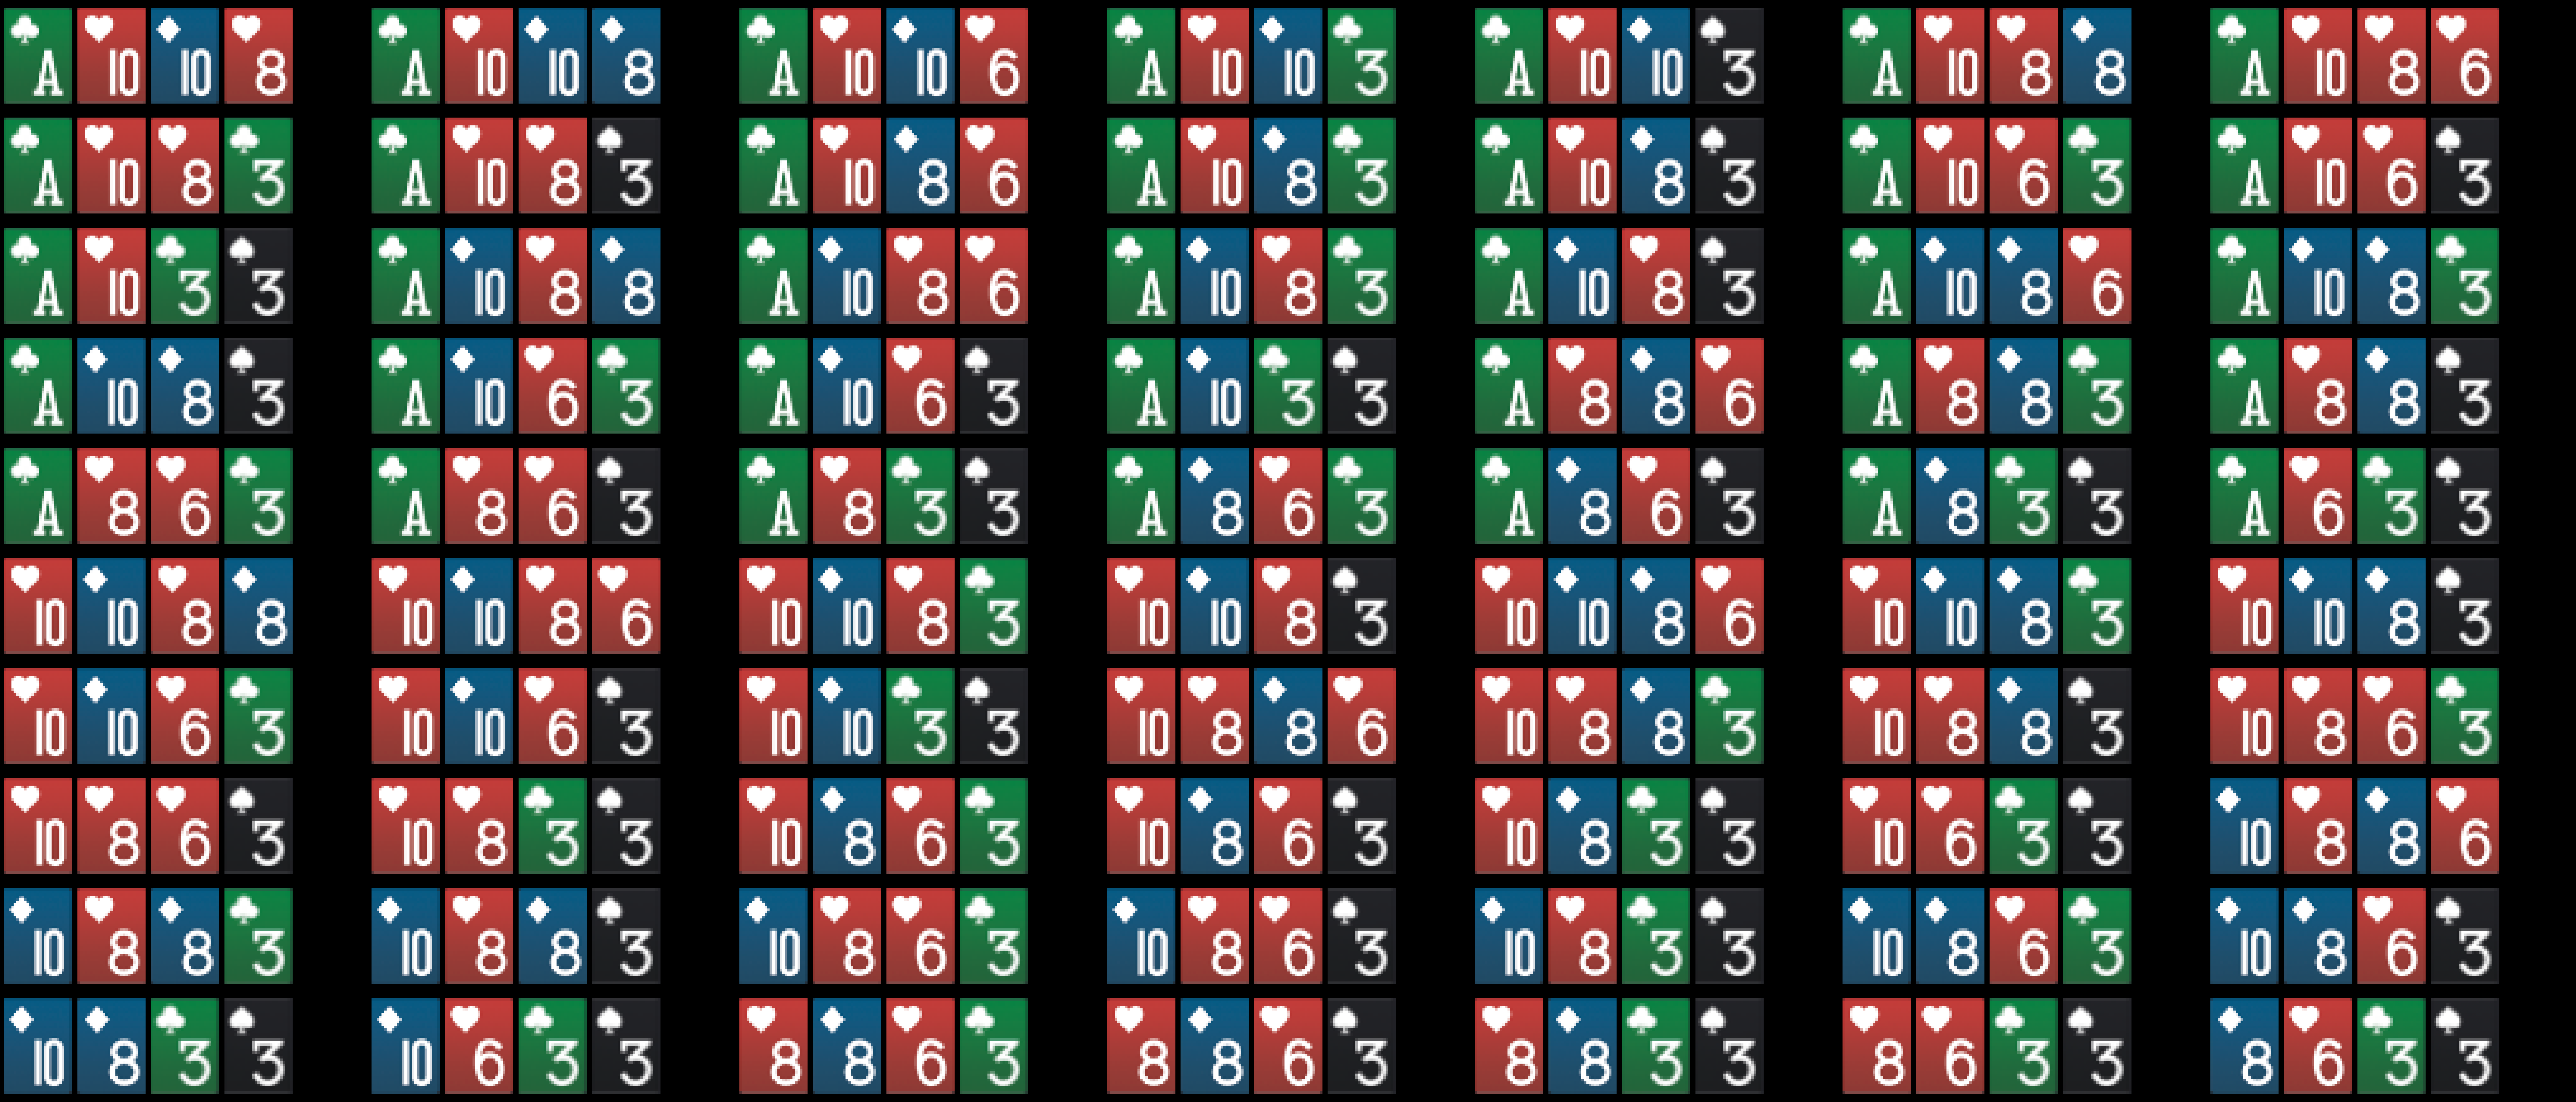

In [19]:
root_dir = 'C:/Users/Admin/Desktop/Primary Skills/Programming & ML/Machine Learning/Kaggle/Card Detection/Card Images'

def plot_combinations(combinations_list):
    n_rows = 10
    n_cols = 7 * 5  # 7 columns of combos (each combo has 4 cards + 1 white space)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 3))
    fig.patch.set_facecolor('black')

    for k, combo in enumerate(combinations_list):
        row = k // 7
        col = (k % 7) * 5  
        for j, card in enumerate(combo):
            img_path = os.path.join(root_dir, card + ".png")
            img = Image.open(img_path)
            axes[row, col + j].imshow(img)
            axes[row, col + j].axis('off')
            axes[row, col + j].set_title('')

        # Set the last column in the current combo to white
        axes[row, col + 4].axis('off')
        axes[row, col + 4].set_title('')
        axes[row, col + 4].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

print(f"Unique Combos: {len(sorted_card_combinations)}")
plot_combinations(sorted_card_combinations)